In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.mstats import mquantiles
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

In [2]:
conn = psycopg2.connect(dbname='bw', user='user9', 
                        password='Y7aMlL1x', host='88.212.254.23')
cursor = conn.cursor()

# Intro

## Considering, which tables will be useful for the task

In [3]:
cursor.execute('SELECT TABLE_NAME, COLUMN_NAME FROM INFORMATION_SCHEMA.COLUMNS')
arr = np.array(cursor.fetchall())
arr_split = np.split(arr, np.where(arr[:-1,0] != arr[1:,0])[0]+1)
dict_tables = {}

# print('Tables with corresponding columns\n')

# for tbl in arr_split:
    
#     print('{}:'.format(tbl[0,0]))
#     dict_tables[tbl[0,0]] = tbl[:,1]
    
#     for clm in tbl:
        
#         print('\t\t{}'.format(clm[1]))

print('Tables:\n')

for i, tbl in enumerate(arr_split):
    
    if i < 10:
        print('{}'.format(tbl[0,0]))
    elif i == 10:
        print('...')
    dict_tables[tbl[0,0]] = tbl[:,1]

Tables:

pg_proc
pg_type
pg_attribute
pg_class
pg_attrdef
pg_constraint
pg_inherits
pg_index
pg_operator
pg_opfamily
...


Clearly, we are not interested in the majority of the utilitarian tables.

Also, some tables are repeating and give incoherent info.

Table **t** was thrown away since it's just a copy of orders, **t1** is a little bit manipulated **t**.
**kurs**-es contain irrelevant info about currencies.
**inv_orders**, **inv_customers**, **products2** and **product_groups** contain data, which do not match with the rest of relevant tables.

Thus, we are left with 4 tables: **orders**, **products**, **line_items** and **customers**

Schema of dependencies between 4 tables is following: (https://dbdiagram.io/d/60a919c0b29a09603d160e95)

![SQL diagram](https://i.postimg.cc/0y59xh8b/Test-Problem.png)

Note: half of the time **line_items.amount** is not equal to the **line_items.quantity** $\times$ **products.price**

At first, I will consider those tables separately to understand the nature of the data inside the schema and their major trends. And after that I will answer the test problems with usage of several tables simultaneously.

## Orders

In [4]:
cursor.execute('SELECT * FROM orders')
ords = np.array(cursor.fetchall())
df_orders = pd.DataFrame(ords, columns=dict_tables['orders'])

In [5]:
df_orders

id  order_date   ship_date       ship_mode customer_id  \
0     CA-2014-100006  2014-09-07  2014-09-13  Standard Class    DK-13375   
1     CA-2014-100090  2014-07-08  2014-07-12  Standard Class    EB-13705   
2     CA-2014-100293  2014-03-14  2014-03-18  Standard Class    NF-18475   
3     CA-2014-100328  2014-01-28  2014-02-03  Standard Class    JC-15340   
4     CA-2014-100363  2014-04-08  2014-04-15  Standard Class    JM-15655   
...              ...         ...         ...             ...         ...   
5004  US-2017-168802  2017-11-03  2017-11-07  Standard Class    JO-15145   
5005  US-2017-169320  2017-07-23  2017-07-25    Second Class    LH-16900   
5006  US-2017-169488  2017-09-07  2017-09-09     First Class    AA-10375   
5007  US-2017-169502  2017-08-28  2017-09-01  Standard Class    MG-17650   
5008  US-2017-169551  2017-07-07  2017-07-09     First Class    RL-19615   

        sales     y  
0      377.97  None  
1     699.192  None  
2      91.056  None  
3       3.928  None  
4      21.376  None  
...       ...   ...  
5004   18.368  None  
5005   171.43  None  
5006    56.86  None  
5007   113.41  None  
5008  1344.84  None  

[5009 rows x 7 columns]

In [6]:
df_orders.describe()

id  order_date   ship_date       ship_mode customer_id  \
count             5009        5009        5009            5009        5009   
unique            5009        1237        1334               4         793   
top     US-2017-129224  2016-09-05  2017-11-16  Standard Class    EP-13915   
freq                 1          19          17            2994          17   

          sales    y  
count   5009.00    0  
unique  4512.00    0  
top       12.96  NaN  
freq      14.00  NaN

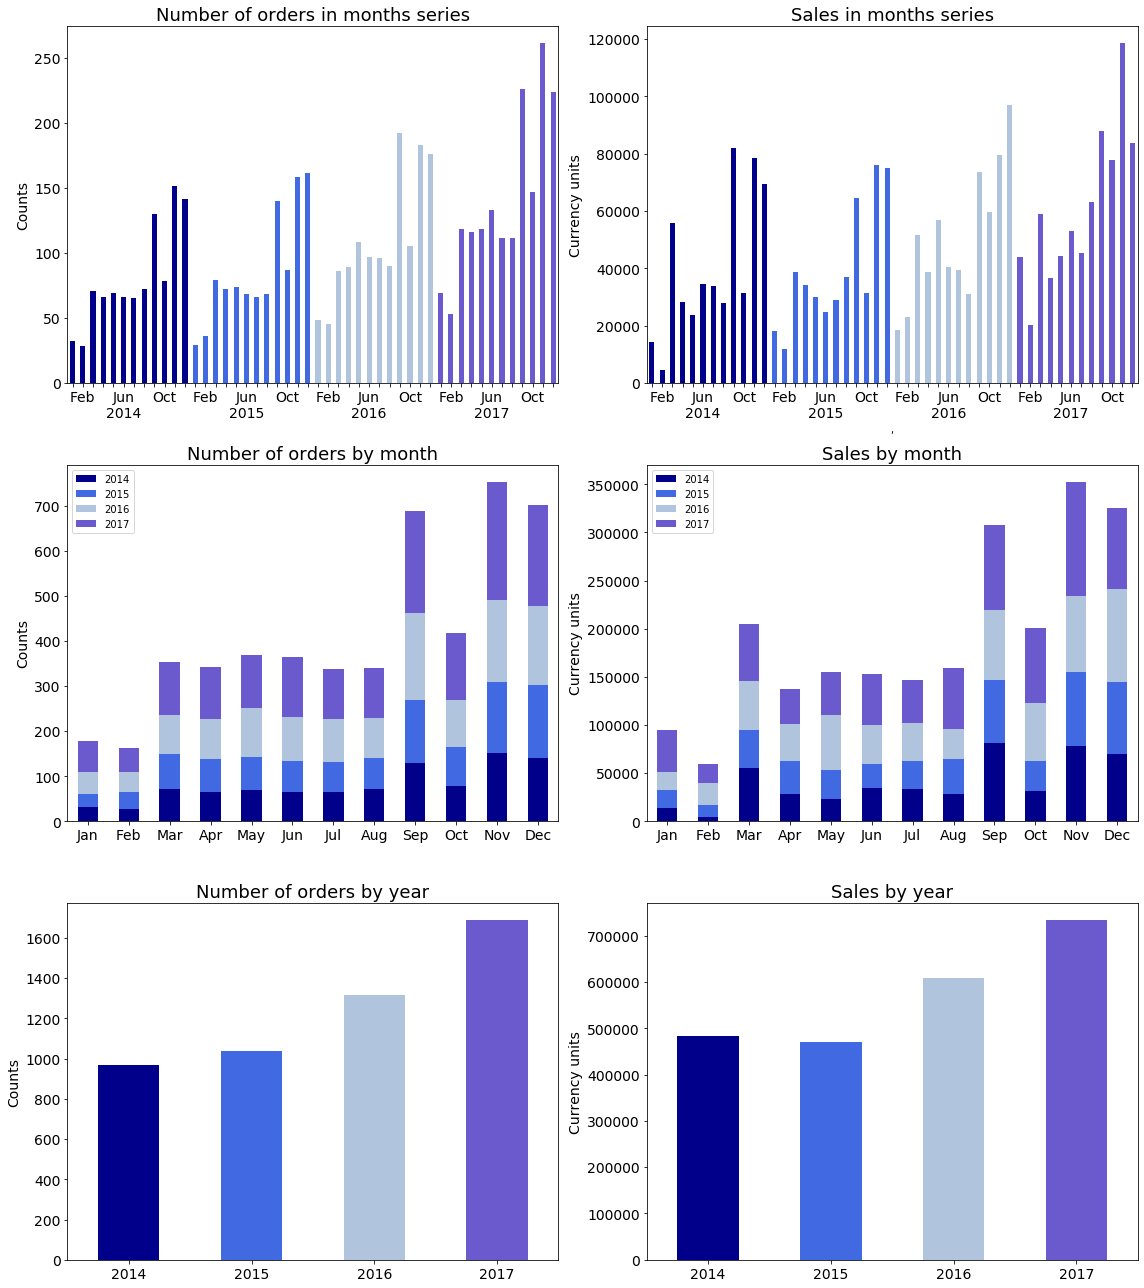

In [7]:
# orders dynamic (year and month)
cursor.execute('SELECT order_date FROM orders ORDER BY order_date ASC')
ord_dates = pd.Series(np.array(cursor.fetchall())[:,0])
ord_dates = ord_dates.astype("datetime64")
ord_ym = ord_dates.groupby([ord_dates.dt.year, ord_dates.dt.month]).count()
colors = ['darkblue', 'royalblue', 'lightsteelblue', 'slateblue']
ym_colors = list(map(lambda x: colors[(x+2) % 4], list(zip(*ord_ym.index))[0]))

def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label[1]
    if month == 2:
        return 'Feb'
    elif month == 6:
        return 'Jun\n'+str(int(label[0]))
    elif month == 10:
        return 'Oct'
    else:
        return None

# order distribution (years)
ord_y = ord_dates.groupby(ord_dates.dt.year).count()
y_colors = list(map(lambda x: colors[(x+2) % 4], ord_y.index))

# order distribution (months)
months = [ord_ym[year] for year in ord_y.index]
df_months_n = pd.concat(months, axis=1, sort=False)
df_months_n.columns = ord_y.index
df_months_n.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# sales dynamic (year and month)
cursor.execute('SELECT order_date, sales FROM orders ORDER BY order_date ASC')
ord_sales = pd.DataFrame(cursor.fetchall(), columns=['order_date', 'sales'])
ord_sales['order_date'] = ord_sales['order_date'].astype("datetime64")
ord_sales_ym = ord_sales.groupby([ord_sales['order_date'].dt.year, ord_sales['order_date'].dt.month]).agg({'sales': 'sum'}).iloc[:,0]
ord_sales_ym = ord_sales_ym.rename_axis(index={'order_date': ''})

# sales distribution (years)
ord_sales_y = ord_sales.groupby(ord_sales['order_date'].dt.year).agg({'sales': 'sum'}).iloc[:,0]
ord_sales_y = ord_sales_y.rename_axis(index={'order_date': ''})

# sales distribution (months)
months = [ord_sales_ym[year] for year in ord_y.index]
df_months_s = pd.concat(months, axis=1, sort=False)
df_months_s.columns = ord_y.index
df_months_s.index = df_months_n.index

# plot
fig, axes = plt.subplots(figsize=(16,18), nrows=3, ncols=2)

ax=axes[0,0]
ord_ym.plot(ax=ax, kind="bar", fontsize=14, rot=0, color=ym_colors)
ax.set_xticklabels(map(line_format, ord_ym.index))
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of orders in months series', fontsize=18)

ax=axes[1,0]
df_months_n.plot(ax=ax, kind='bar', fontsize=14, rot=0, stacked=True, color=y_colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of orders by month', fontsize=18)

ax=axes[2,0]
ord_y.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=y_colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of orders by year', fontsize=18)

ax=axes[0,1]
ord_sales_ym.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=ym_colors)
ax.set_xticklabels(map(line_format, ord_sales_ym.index))
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales in months series', fontsize=18)

ax=axes[1,1]
df_months_s.plot(ax=ax, kind='bar', fontsize=14, rot=0, stacked=True, color=y_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by month', fontsize=18)

ax=axes[2,1]
ord_sales_y.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=y_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by year', fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: orders throughout all 4 years carry pronounced periodic dynamic, localized in the timeframe of year. The long-term trend is the increase of the number of orders and sales. The best months are September, November and December with 2 probable explanations why: 1. Autumn-Winter is the season of holidays with high amount of customers. 2. The end of the year id the time of finishing year-time accounting reports and spending the dedicated money tranches. The worst months are January and February as the season right after big end-of-year spending.

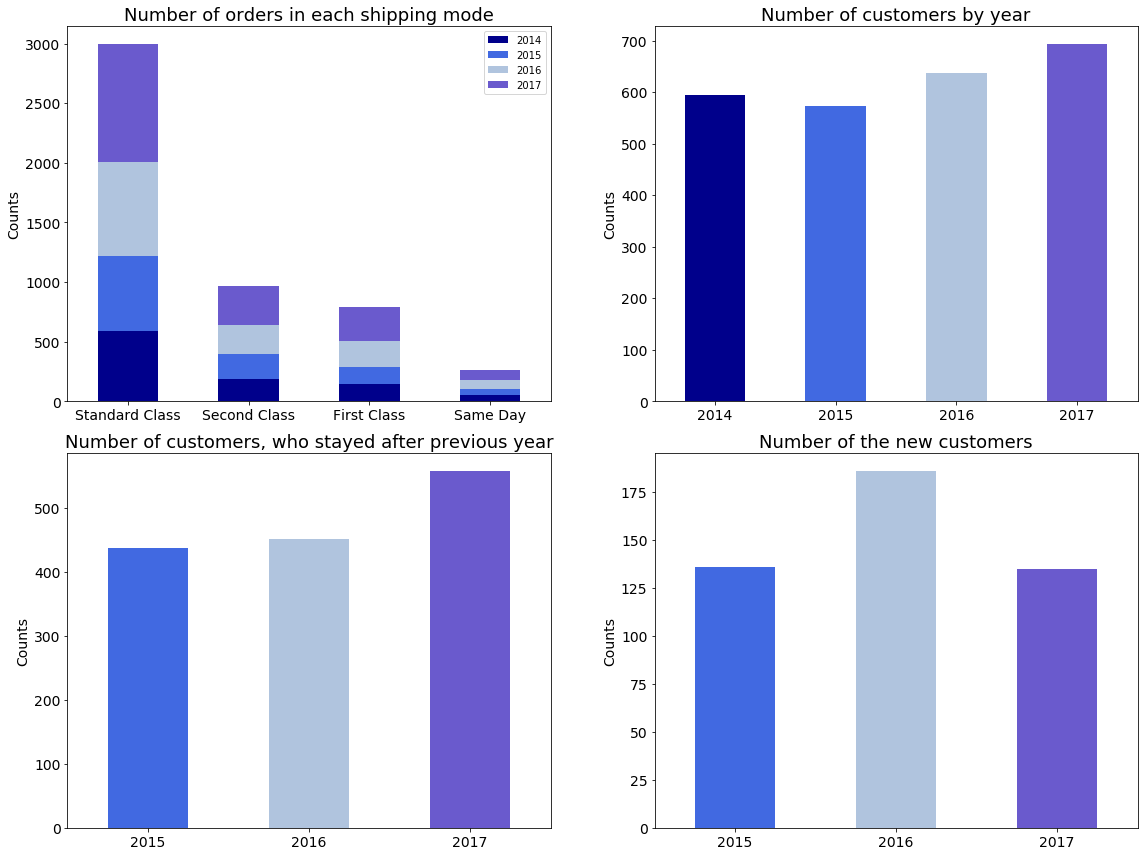

In [8]:
# shipping modes distribution
cursor.execute('SELECT order_date, ship_mode FROM orders ORDER BY order_date ASC')
ord_modes = pd.DataFrame(cursor.fetchall(), columns=['order_date', 'ship_mode'])
ord_modes['order_date'] = ord_modes['order_date'].astype("datetime64")

ord_modes_y = ord_modes.groupby([ord_modes['order_date'].dt.year, ord_modes['ship_mode']]).agg({'ship_mode': 'count'}).iloc[:,0]
ord_modes_y = ord_modes_y.rename_axis(index={'order_date': '', 'ship_mode': ''})

modes_sorted = df_orders['ship_mode'].value_counts()
modes = [ord_modes_y[year] for year in ord_y.index]
df_modes = pd.concat(modes, axis=1, sort=False)
df_modes.columns = ord_y.index
df_modes = df_modes.reindex(index = modes_sorted.index)

# number of customers dynamic
cursor.execute('SELECT order_date, customer_id FROM orders ORDER BY order_date ASC')
ord_cust = pd.DataFrame(cursor.fetchall(), columns=['order_date', 'customer_id'])
ord_cust['order_date'] = ord_cust['order_date'].astype("datetime64")
# ord_cust_y = ord_cust.groupby(ord_cust['order_date'].dt.year).agg({'customer_id': 'count'}).iloc[:,0]
# ord_cust_y = ord_cust_y.rename_axis(index={'order_date': ''})
ord_cust_stay = ord_cust.copy()
ord_cust_stay['order_date'] = ord_cust_stay['order_date'].dt.year
ord_cust_s = []
for year in ord_y.index:
    ord_cust_s.append(pd.Series(ord_cust_stay[ord_cust_stay['order_date'] == year].iloc[:,1].unique(), name='customer_id'))
ord_cust_y = pd.Series([ord_cust_s[i].size for i in range(len(ord_y.index))], index=ord_y.index)

# staying customers
stay = pd.Series([pd.merge(ord_cust_s[i-1], ord_cust_s[i], how='inner', on='customer_id').size for i in range(1, len(ord_y.index))], index=ord_y.index[1:])

# new customers
new = ord_cust_y.iloc[1:] - stay

# plot
fig, axes = plt.subplots(figsize=(16,12), nrows=2, ncols=2)

ax=axes[0,0]
df_modes.plot(ax=ax, kind="bar", rot=0, fontsize=14, stacked=True, color=y_colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of orders in each shipping mode', fontsize=18)

ax=axes[0,1]
ord_cust_y.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=y_colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of customers by year', fontsize=18)

ax=axes[1,0]
stay.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=y_colors[1:])
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of customers, who stayed after previous year', fontsize=18)

ax=axes[1,1]
new.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=y_colors[1:])
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of the new customers', fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: number of customers is growing each year, and the amount of customers, who decided to come back to shopping in the company is increasing; but the amount of new customers overall does not change. It may indicate the lack of marketing or insufficient work of sales department (the market of office goods does not seem to be covered, so the saturation is unlikely). The distribution of shipping modes seems to be standard, with increasing amounts by years.

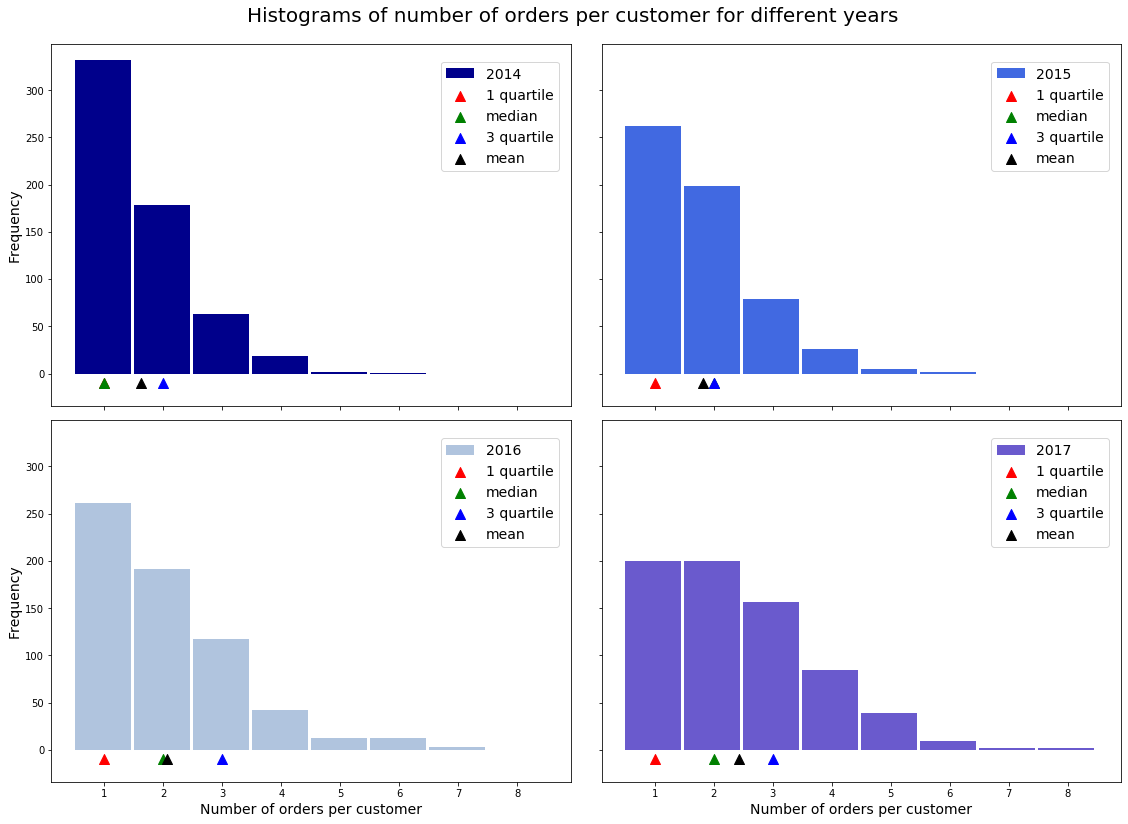

In [9]:
# histograms for orders per customer
cursor.execute('SELECT order_date, customer_id, id FROM orders ORDER BY order_date ASC')
ord_npc = pd.DataFrame(cursor.fetchall(), columns=['order_date', 'customer_id', 'id'])
ord_npc['order_date'] = ord_npc['order_date'].astype("datetime64")
ord_npc_y = ord_npc.groupby([ord_npc['order_date'].dt.year, ord_npc['customer_id']]).agg({'id': 'count'}).iloc[:,0]
ord_npc_y = ord_npc_y.rename_axis(index={'order_date': '', 'customer_id': ''})

# plot
fig, axes = plt.subplots(figsize=(16,12), nrows=2, ncols=2, sharex=True, sharey=True)
fig.suptitle('Histograms of number of orders per customer for different years', fontsize=20)

for year in ord_y.index:
    
    ax=axes[0 if year < 2016 else 1, year % 2]
    arr = np.array(ord_npc_y[year])
    ax.hist(arr, bins=np.linspace(1,9,9), color=y_colors[(year+2) % 4], width=0.95, label=year, align='left')
    if year % 2 == 0:
        ax.set_ylabel('Frequency', fontsize=14)
    if year >= 2016:
        ax.set_xlabel('Number of orders per customer', fontsize=14)
    q1, q2, q3 = mquantiles(arr)
    ax.scatter(q1, -10, s=100, marker='^', color='red', label='1 quartile')
    ax.scatter(q2, -10, s=100, marker='^', color='green', label='median')
    ax.scatter(q3, -10, s=100, marker='^', color='blue', label='3 quartile')
    ax.scatter(np.mean(arr), -10, s=100, marker='^', color='black', label='mean')
    ax.legend(bbox_to_anchor=(0.75, 0.95), loc=2, borderaxespad=0., fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Inference**: number of orders is not only increasing, but also the right tail of the order-per-customer histogram becomes heavier (1. visually, 2. mean is growing). It means that customers are proceeding to trust the company and consider it more valuable, thus coming back once more to make the order.

## Products

In [10]:
cursor.execute('SELECT * FROM products')
prods = np.array(cursor.fetchall())
df_products = pd.DataFrame(prods, columns=dict_tables['products'])

In [11]:
df_products

id         category sub_category  \
0     OFF-ST-10001328  Office Supplies      Storage   
1     OFF-ST-10001370  Office Supplies      Storage   
2     OFF-ST-10001414  Office Supplies      Storage   
3     OFF-ST-10001418  Office Supplies      Storage   
4     OFF-ST-10001469  Office Supplies      Storage   
...               ...              ...          ...   
1857  OFF-ST-10001228  Office Supplies      Storage   
1858  OFF-ST-10001272  Office Supplies      Storage   
1859  OFF-ST-10001291  Office Supplies      Storage   
1860  OFF-ST-10001321  Office Supplies      Storage   
1861  OFF-ST-10001325  Office Supplies      Storage   

                                                   name   price  
0             Personal Filing Tote with Lid, Black/Gray  12.408  
1             Sensible Storage WireTech Storage Systems   70.98  
2                 Decoflex Hanging Personal Folder File   15.42  
3        Carina Media Storage Towers in Natural & Black   60.98  
4       Fellowes Bankers Box Recycled Super Stor/Drawer   53.98  
...                                                 ...     ...  
1857       Fellowes Personal Hanging Folder Files, Navy   13.43  
1858       Mini 13-1/2 Capacity Data Binder Rack, Pearl  130.87  
1859  Tenex Personal Self-Stacking Standard File Box...  13.528  
1860        Decoflex Hanging Personal Folder File, Blue   15.42  
1861               Sterilite Officeware Hinged File Box   8.384  

[1862 rows x 5 columns]

In [12]:
df_products.describe()

id         category sub_category     name price
count              1862             1862         1862     1862  1862
unique             1862                3           17     1818  1344
top     OFF-EN-10001415  Office Supplies        Paper  Staples  6.48
freq                  1             1083          276       10    38

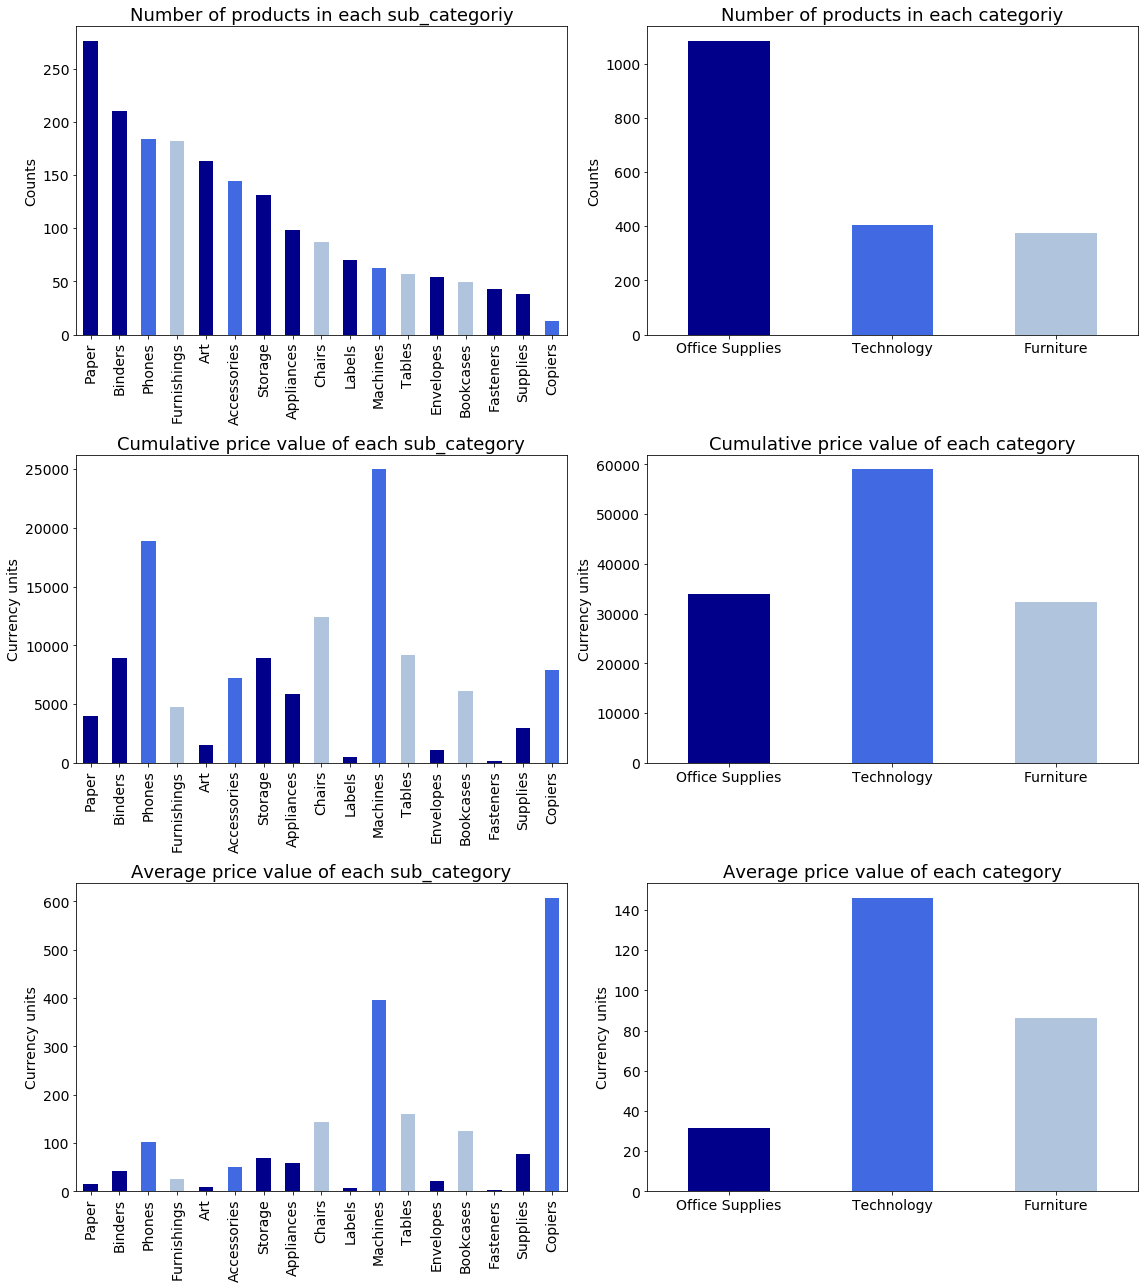

In [13]:
# number of (sub_)categories and colors
cursor.execute('SELECT DISTINCT sub_category, category FROM products')
sub_cat_2_cat = dict(cursor.fetchall())
cursor.execute('SELECT DISTINCT category FROM products')
categories = np.array(cursor.fetchall())[:,0]
colors = ['darkblue', 'royalblue', 'lightsteelblue']
cat_2_color = {}
for cat, col in zip(categories, colors):
    cat_2_color[cat] = col
sub_categories_sorted = df_products['sub_category'].value_counts()
categories_sorted = df_products['category'].value_counts()
sub_cat_colors = [cat_2_color[y] for y in [sub_cat_2_cat[x] for x in sub_categories_sorted.index]]
cat_colors = [cat_2_color[y] for y in categories_sorted.index]

# total prices
cursor.execute('SELECT sub_category, SUM(price) price FROM products GROUP BY sub_category ORDER BY count(*) DESC')
s_sub_cat_price = pd.Series(dict(cursor.fetchall()))
cursor.execute('SELECT category, SUM(price) price FROM products GROUP BY category ORDER BY count(*) DESC')
s_cat_price = pd.Series(dict(cursor.fetchall()))

# average prices
cursor.execute('SELECT sub_category, AVG(price) price FROM products GROUP BY sub_category ORDER BY count(*) DESC')
s_sub_cat_avg_price = pd.Series(dict(cursor.fetchall()))
cursor.execute('SELECT category, AVG(price) price FROM products GROUP BY category ORDER BY count(*) DESC')
s_cat_avg_price = pd.Series(dict(cursor.fetchall()))

# plot
fig, axes = plt.subplots(figsize=(16,18), nrows=3, ncols=2)

ax = axes[0,0]
sub_categories_sorted.plot(ax=ax, kind='bar', fontsize=14, color=sub_cat_colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of products in each sub_categoriy', fontsize=18)

ax = axes[0,1]
categories_sorted.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=cat_colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of products in each categoriy', fontsize=18)

ax=axes[1,0]
s_sub_cat_price.plot(ax=ax, kind='bar', fontsize=14, color=sub_cat_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Cumulative price value of each sub_category', fontsize=18)

ax=axes[1,1]
s_cat_price.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=cat_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Cumulative price value of each category', fontsize=18)

ax=axes[2,0]
s_sub_cat_avg_price.plot(ax=ax, kind='bar', fontsize=14, color=sub_cat_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Average price value of each sub_category', fontsize=18)

ax=axes[2,1]
s_cat_avg_price.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=cat_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Average price value of each category', fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: the biggest amount of different products is, as expected, inside the cheapest category -- Office Supplies. The most valuable category is Technology with 2 most expensive sub_categories -- Copiers and Machines.

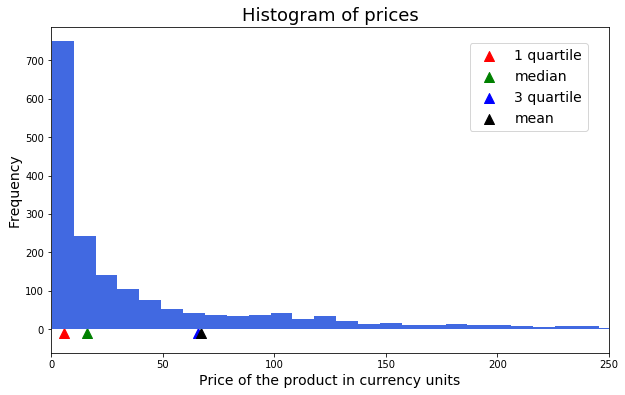

In [14]:
cursor.execute('SELECT price FROM products')
prices = np.array(cursor.fetchall())[:,0]
q1, q2, q3 = mquantiles(prices)

plt.figure(figsize = (10,6))
plt.hist(prices, bins='auto', color='royalblue')
plt.scatter(q1, -10, s=100, marker='^', color='red', label='1 quartile')
plt.scatter(q2, -10, s=100, marker='^', color='green', label='median')
plt.scatter(q3, -10, s=100, marker='^', color='blue', label='3 quartile')
plt.scatter(np.mean(prices), -10, s=100, marker='^', color='black', label='mean')
plt.xlim([0, 250])
plt.title('Histogram of prices', fontsize=18)
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Price of the product in currency units', fontsize=14)
plt.legend(bbox_to_anchor=(0.75, 0.95), loc=2, borderaxespad=0., fontsize=14)
plt.show()

**Inference**: the distribution is highly positively-skewed (just look at the difference between mean and median) with large amount of common and extreme outliers. The half of the prices is located between 0 and 20 currency units (dollars?).

## Line_items

In [15]:
cursor.execute('SELECT * FROM line_items')
li = np.array(cursor.fetchall())
df_line_items = pd.DataFrame(li, columns=dict_tables['line_items'])

In [16]:
df_line_items

order_id       product_id    amount quantity
0     CA-2016-152156  FUR-BO-10001798    261.96        2
1     CA-2016-152156  FUR-CH-10000454    731.94        3
2     CA-2016-138688  OFF-LA-10000240     14.62        2
3     US-2015-108966  FUR-TA-10000577  957.5775        5
4     US-2015-108966  OFF-ST-10000760    22.368        2
...              ...              ...       ...      ...
9981  CA-2014-110422  FUR-FU-10001889    25.248        3
9982  CA-2017-121258  FUR-FU-10000747     91.96        2
9983  CA-2017-121258  TEC-PH-10003645   258.576        2
9984  CA-2017-121258  OFF-PA-10004041      29.6        4
9985  CA-2017-119914  OFF-AP-10002684    243.16        2

[9986 rows x 4 columns]

In [17]:
df_line_items.describe()

order_id       product_id amount quantity
count             9986             9986   9986     9986
unique            5009             1862   5823       14
top     CA-2017-100111  TEC-AC-10003832  12.96        3
freq                14               18     56     2407

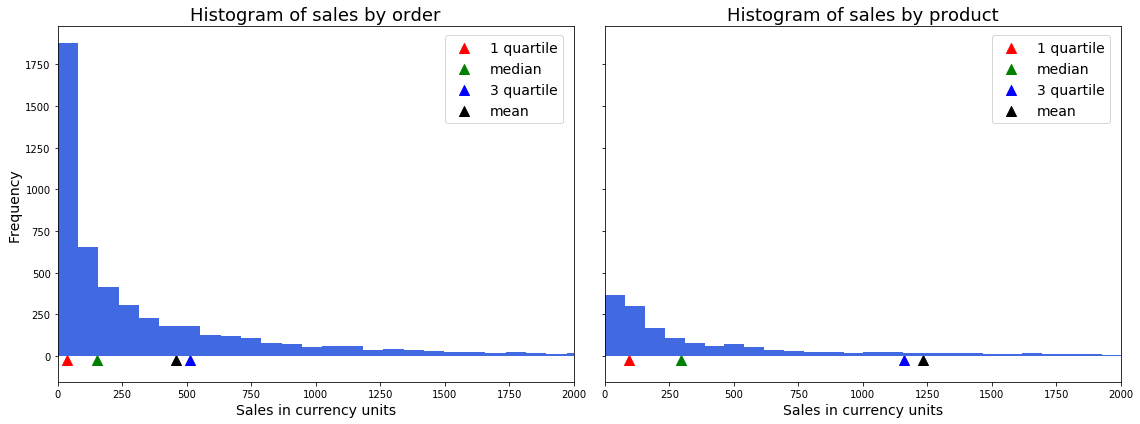

In [18]:
cursor.execute('SELECT order_id, SUM(amount) amount FROM line_items GROUP BY order_id ORDER BY count(*) DESC')
ord_amount = np.array(cursor.fetchall())[:,1].astype(np.float)
q1o, q2o, q3o = mquantiles(ord_amount)

cursor.execute('SELECT product_id, SUM(amount) amount FROM line_items GROUP BY product_id ORDER BY count(*) DESC')
prod_amount = np.array(cursor.fetchall())[:,1].astype(np.float)
q1p, q2p, q3p = mquantiles(prod_amount)

fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=2, sharey=True)

ax = axes[0]
ax.hist(ord_amount, bins=300, color='royalblue')
ax.scatter(q1o, -25, s=100, marker='^', color='red', label='1 quartile')
ax.scatter(q2o, -25, s=100, marker='^', color='green', label='median')
ax.scatter(q3o, -25, s=100, marker='^', color='blue', label='3 quartile')
ax.scatter(np.mean(ord_amount), -25, s=100, marker='^', color='black', label='mean')
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Histogram of sales by order', fontsize=18)
ax.set_xlim([0, 2000])
ax.set_xlabel('Sales in currency units', fontsize=14)
ax.legend(bbox_to_anchor=(0.75, 0.975), loc=2, borderaxespad=0., fontsize=14)

ax=axes[1]
ax.hist(prod_amount, bins=800, color='royalblue')
ax.scatter(q1p, -25, s=100, marker='^', color='red', label='1 quartile')
ax.scatter(q2p, -25, s=100, marker='^', color='green', label='median')
ax.scatter(q3p, -25, s=100, marker='^', color='blue', label='3 quartile')
ax.scatter(np.mean(prod_amount), -25, s=100, marker='^', color='black', label='mean')
ax.set_title('Histogram of sales by product', fontsize=18)
ax.set_xlim([0, 2000])
ax.set_xlabel('Sales in currency units', fontsize=14)
ax.legend(bbox_to_anchor=(0.75, 0.975), loc=2, borderaxespad=0., fontsize=14)

fig.tight_layout()
plt.show()

**Inference**: the mean of sales by product is greater than 3rd quartile, which means that the tail of the distribution is really heavy. So, even expensive products were well sold throughout 4 years. Sales by order have lower variance, so the majority of orders were made with small sales (half of them between 0 and 180 currency units).

## Customers

In [19]:
cursor.execute('SELECT * FROM customers')
cus = np.array(cursor.fetchall())
df_customers = pd.DataFrame(cus, columns=dict_tables['customers'])

In [20]:
df_customers

id               name      segment        country           state  \
0    DV-13045    Darrin Van Huff    Corporate  United States      California   
1    SO-20335     Sean O'Donnell     Consumer  United States         Florida   
2    BH-11710    Brosina Hoffman     Consumer  United States      California   
3    AA-10480       Andrew Allen     Consumer  United States  North Carolina   
4    IM-15070       Irene Maddox     Consumer  United States      Washington   
..        ...                ...          ...            ...             ...   
788  RS-19870         Roy Skaria  Home Office  United States            Iowa   
789  SC-20845         Sung Chung     Consumer  United States        Illinois   
790  RE-19405    Ricardo Emerson     Consumer  United States            Ohio   
791  SM-20905  Susan MacKendrick     Consumer  United States            Ohio   
792  CG-12520        Claire Gute     Consumer  United States        Kentucky   

                  city postal_code   region  
0          Los Angeles       90036     West  
1      Fort Lauderdale       33311    South  
2          Los Angeles       90032     West  
3              Concord       28027    South  
4              Seattle       98103     West  
..                 ...         ...      ...  
788         Burlington       52601  Central  
789  Arlington Heights       60004  Central  
790               Kent       44240     East  
791             Newark       43055     East  
792          Henderson       42420    South  

[793 rows x 8 columns]

In [21]:
df_customers.describe()

id       name   segment        country       state  \
count        793        793       793            793         793   
unique       793        793         3              1          41   
top     GT-14710  Joy Bell-  Consumer  United States  California   
freq           1          1       409            793         161   

                 city postal_code region  
count             793         793    793  
unique            252         314      4  
top     New York City       10035   West  
freq               68          21    255

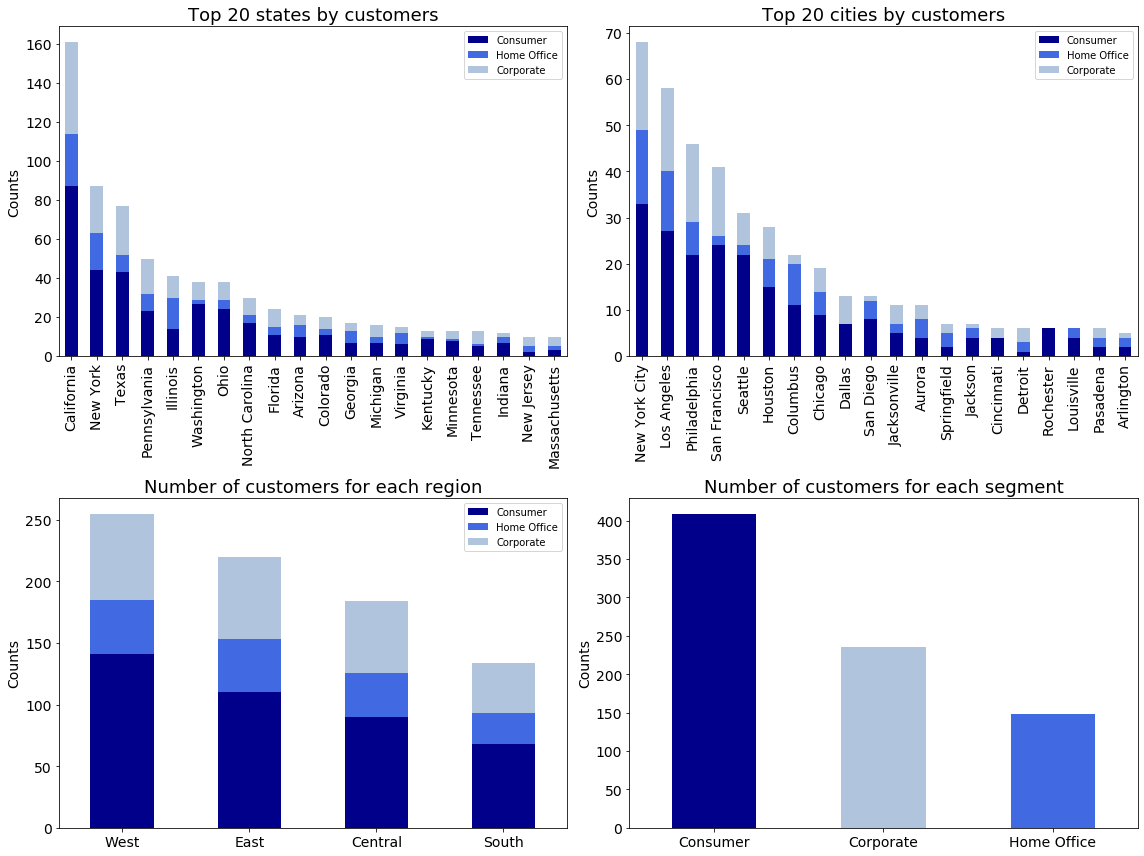

In [22]:
n = 20

# segments and colors
cursor.execute('SELECT DISTINCT segment FROM customers')
segments = np.array(cursor.fetchall())[:,0]
seg_2_color = {}
for seg, col in zip(segments, colors):
    seg_2_color[seg] = col
segments_sorted = df_customers['segment'].value_counts()
seg_colors = [seg_2_color[y] for y in segments_sorted.index]

# states
states = []
states_sorted = df_customers['state'].value_counts()
for s in segments:
    cursor.execute('SELECT state, count(state) FROM customers WHERE segment = %s GROUP BY state', (s, ))
    states.append(pd.Series(dict(cursor.fetchall()), name=s, index=states_sorted.index))
states_by_segments = pd.concat(states, axis=1, sort=False)

# cities
cities = []
cities_sorted = df_customers['city'].value_counts()
for s in segments:
    cursor.execute('SELECT city, count(city) FROM customers WHERE segment = %s GROUP BY city', (s, ))
    cities.append(pd.Series(dict(cursor.fetchall()), name=s, index=cities_sorted.index))
cities_by_segments = pd.concat(cities, axis=1, sort=False)

# regions
regions = []
regions_sorted = df_customers['region'].value_counts()
for s in segments:
    cursor.execute('SELECT region, count(region) FROM customers WHERE segment = %s GROUP BY region', (s, ))
    regions.append(pd.Series(dict(cursor.fetchall()), name=s, index=regions_sorted.index))
regions_by_segments = pd.concat(regions, axis=1, sort=False)

#plot
fig, axes = plt.subplots(figsize=(16,12), nrows=2, ncols=2)

ax = axes[0,0]
states_by_segments[:n].plot(ax=ax, kind='bar', fontsize=14, stacked=True, color=colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Top {} states by customers'.format(n), fontsize=18)

ax=axes[0,1]
cities_by_segments[:n].plot(ax=ax, kind='bar', fontsize=14, stacked=True, color=colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Top {} cities by customers'.format(n), fontsize=18)

ax=axes[1,0]
regions_by_segments.plot(ax=ax, kind='bar', fontsize=14, stacked=True, rot=0, color=colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of customers for each region', fontsize=18)

ax=axes[1,1]
segments_sorted.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=seg_colors)
ax.set_ylabel('Counts', fontsize=14)
ax.set_title('Number of customers for each segment', fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: The majority of customers is from US megalopolises, which makes sense, since the company sells office goods, mostly required in big cities. The lion's share of customers live in California, which includes 2 out of top-4 cities -- Los Angeles and San Francisco. The coastal regions also predominate the regions distribution. The segments distribution seems standard.

# Answering the actual questions

## 1. Are store sales on the rise or on the fall?

Based on the charts **Sales in months series**, **Sales by month** and **Sales by year** from orders table, we can clearly claim that store sales are on the rise.

## 2. How does the average check change?

Since I have charts for number of orders (in months and years) and total sales (in months and years), but not the average check for the order for any timeframe, let's make required charts:

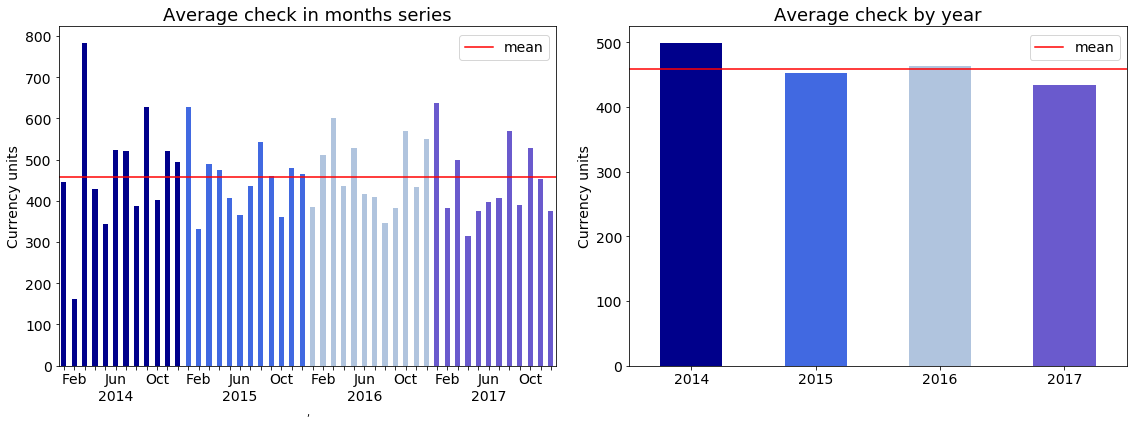

In [23]:
#average check in months
cursor.execute('SELECT extract(year from order_date) as year, extract(month from order_date) as month, AVG(sales) FROM orders GROUP BY year, month ORDER BY year, month ASC')
df_avg_check_ym = pd.DataFrame((cursor.fetchall()), columns=['year', 'month', '']).set_index(['year', 'month'])
s_avg_check_ym = df_avg_check_ym.iloc[:,0]
s_avg_check_ym = s_avg_check_ym.rename_axis(index={'year': '', 'month': ''})

#average check by year
cursor.execute('SELECT extract(year from order_date) as year, AVG(sales) FROM orders GROUP BY year ORDER BY year ASC')
df_avg_check_y = pd.DataFrame((cursor.fetchall()), columns=['year', '']).set_index(['year'])
s_avg_check_y = df_avg_check_y.iloc[:,0]
s_avg_check_y = s_avg_check_y.rename_axis(index={'year': ''})

#average check
cursor.execute('SELECT AVG(sales) FROM orders')
mean = np.array(cursor.fetchall())[0,0]

#plot
fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

ax = axes[0]
s_avg_check_ym.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=ym_colors)
ax.set_xticklabels(map(line_format, s_avg_check_ym.index))
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Average check in months series', fontsize=18)
ax.plot(np.linspace(-1, 48, 100), np.repeat(mean, 100), color='r', label='mean')
ax.legend(bbox_to_anchor=(0.805, 0.975), loc=2, borderaxespad=0., fontsize=14)

ax = axes[1]
s_avg_check_y.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=y_colors, label=None)
ax.set_xticklabels(s_avg_check_y.index.astype(int))
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Average check by year', fontsize=18)
ax.plot(np.linspace(-1, 4, 100), np.repeat(mean, 100), color='r', label='mean')
ax.legend(bbox_to_anchor=(0.805, 0.975), loc=2, borderaxespad=0., fontsize=14)

fig.tight_layout()
plt.show()

Judging by the small difference between year and overall means, I have a suspicion that there is might be no actual difference between average checks for given years.

To test this hypothesis, I will use one-way ANOVA.

**Null hypothesis H0**: there is no difference between actual (population) mean of order value each year

**VS**

**Alternative H1**: there is a difference between actual mean of order value each year

In [24]:
#array of sales for each year
cursor.execute('SELECT extract(year from order_date) as year, sales FROM orders ORDER BY year ASC')
df_sales = pd.DataFrame(cursor.fetchall(), columns=['year', 'sales'])
df_sales['year'] = df_sales['year'].astype(int)

#list of arrays, each array is responsible for one year
sales = [np.array(df_sales[df_sales['year'] == year].iloc[:,1]) for year in ord_y.index]

# ANOVA
F, pvalue = f_oneway(*sales)
print('p-value =', pvalue)

p-value = 0.40322540031271636


In [25]:
#family of Tuckey simultaneous confidence intervals
tukey_test = pairwise_tukeyhsd(df_sales['sales'], df_sales['year'])
print(tukey_test._results_table)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
  2014   2015 -46.4326 0.6741 -156.0328  63.1676  False
  2014   2016 -36.4652 0.7788 -140.3427  67.4123  False
  2014   2017 -65.1127 0.3281 -164.0119  33.7865  False
  2015   2016   9.9674    0.9  -91.9029 111.8377  False
  2015   2017 -18.6801    0.9  -115.469  78.1087  False
  2016   2017 -28.6475 0.8273  -118.905    61.61  False
-------------------------------------------------------


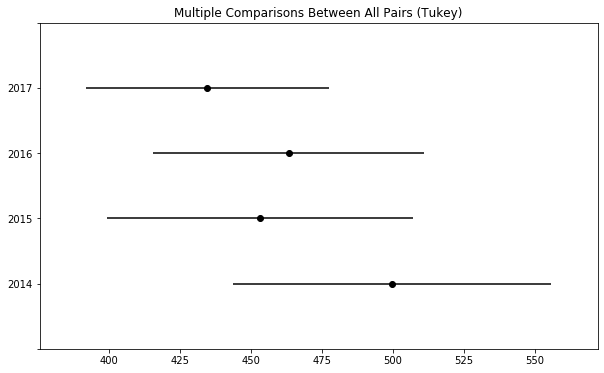

In [26]:
#simultaneous intervals for each year mean
tukey_test.plot_simultaneous()
plt.show()

**Inference**: The p-value is actually very big. It means that the test is insignificant and we have no reasons to reject H0. Also, larger halves of confidence intervals for each year are intersecting.

That's why I assume that the average check does not change in the given timeframe.

## 3. Which product categories and subcategories generated the most revenue?

I need tables **line_items** and **products** for this task.

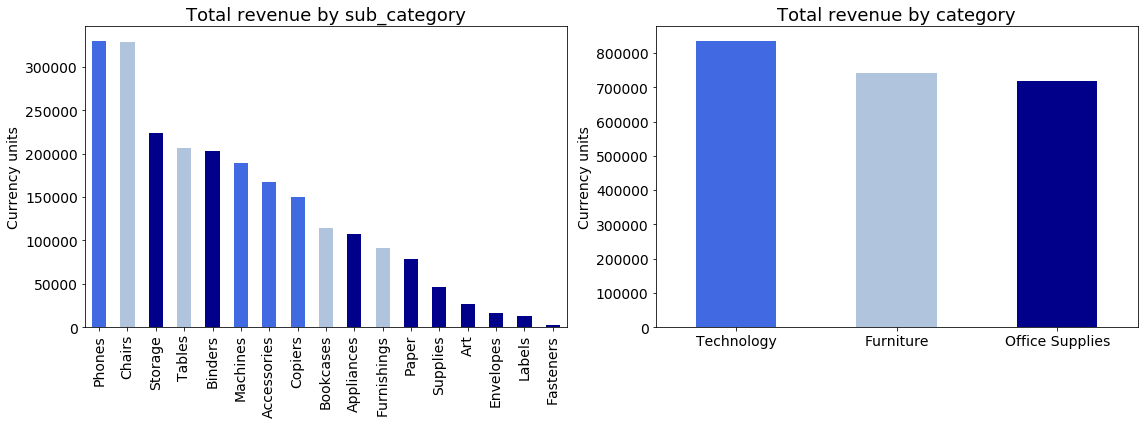

In [27]:
#sales by sub_category
cursor.execute('SELECT sub_category, SUM(amount) amount FROM line_items, products WHERE id = product_id GROUP BY sub_category ORDER BY SUM(amount) DESC')
df_ss = pd.DataFrame(cursor.fetchall(), columns=['sub_category', '']).set_index(['sub_category']).iloc[:,0]
df_ss = df_ss.rename_axis(index={'sub_category': ''})
sub_cat_colors = [cat_2_color[y] for y in [sub_cat_2_cat[x] for x in df_ss.index]]

#sales by category
cursor.execute('SELECT category, SUM(amount) amount FROM line_items, products WHERE id = product_id GROUP BY category ORDER BY SUM(amount) DESC')
df_cs = pd.DataFrame(cursor.fetchall(), columns=['category', '']).set_index(['category']).iloc[:,0]
df_cs = df_cs.rename_axis(index={'category': ''})
cat_colors = [cat_2_color[y] for y in df_cs.index]

#plot
fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

ax = axes[0]
df_ss.plot(ax=ax, kind='bar', fontsize=14, color=sub_cat_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Total revenue by sub_category', fontsize=18)

ax = axes[1]
df_cs.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=sub_cat_colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Total revenue by category', fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: The best category by total revenue is 'Technology', and two best sub_categories, drastically different from the rest, are 'Phones' and 'Chairs'.

## 4. Explain the dynamic of sales in the last 3 months. Which factors influenced the revenue the most?

I have some info about sales in 3 last month in the **Sales by month** chart from **orders** table, where the required info given in bars **Oct**, **Nov** and **Dec** in slateblue color. Let's take a closer look.

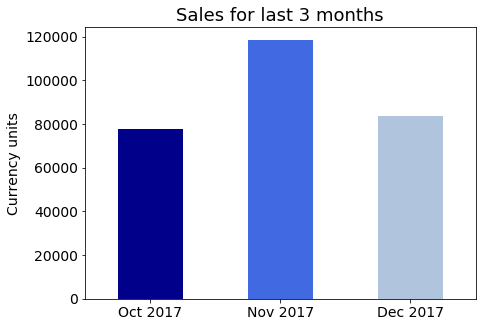

In [28]:
#sales for last 3 months
cursor.execute('SELECT extract(month from order_date) as month, SUM(sales) sales FROM orders \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 \
               GROUP BY month ORDER BY month ASC')

df_3_s = pd.DataFrame(cursor.fetchall(), columns=['month', '']).set_index('month').iloc[:,0]
df_3_s = df_3_s.rename_axis(index={'month': ''})

months_list = ['Oct 2017', 'Nov 2017', 'Dec 2017']

df_3_s.index = months_list

#plot
plt.figure(figsize=(7,5))
df_3_s.plot(kind='bar', rot=0, fontsize=14, color=colors)
plt.title('Sales for last 3 months', fontsize=18)
plt.ylabel('Currency units', fontsize=14)
plt.show()

**Inference**: the amount of sales in Nov 2017 is different from those of Oct and Dec. (I could check that with ANOVA, but I think it's visually clear) Now we need to find out reasons for this behavior.

Firstly, let's see how sales by product categories and sub_cateories are distributed.

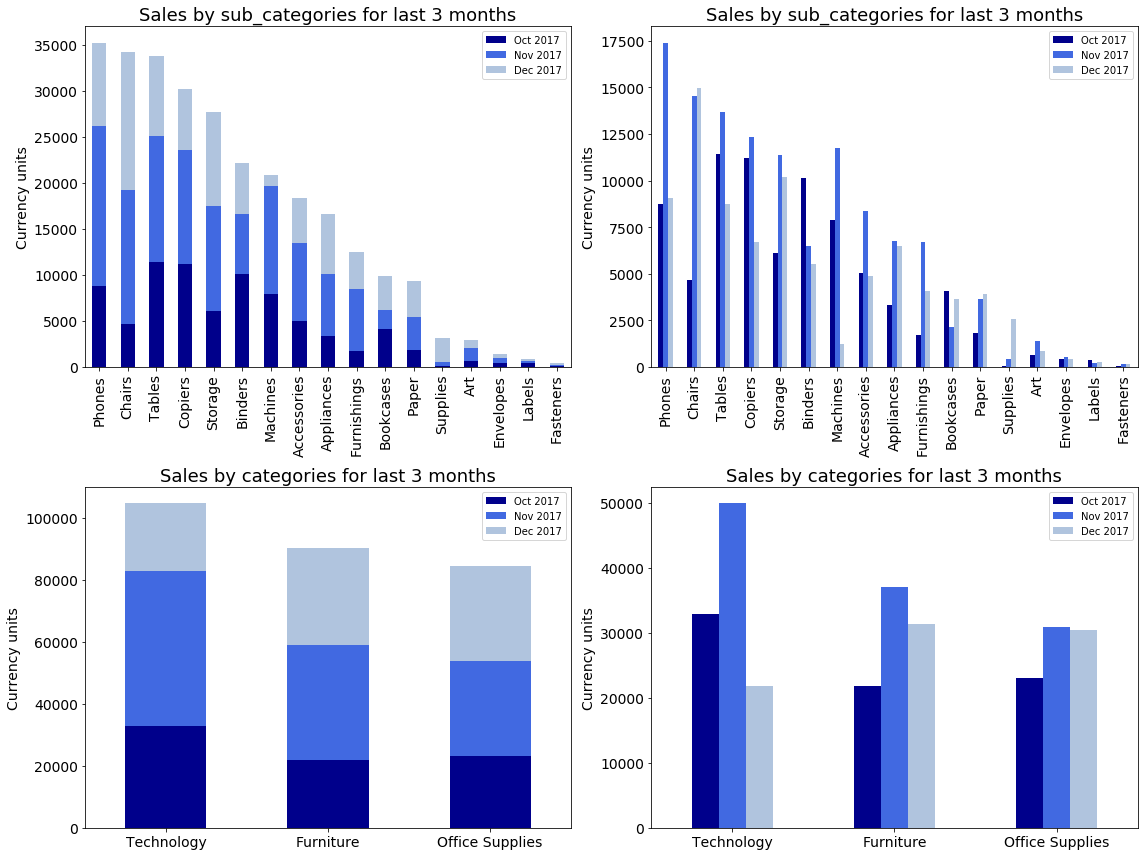

In [29]:
#sales by sub_categories sorted
cursor.execute('SELECT sub_category, SUM(amount) amount \
               FROM orders, line_items, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               products.id = product_id AND orders.id = order_id \
               GROUP BY sub_category ORDER BY SUM(amount) DESC')

sub_cat_sorted = pd.DataFrame(cursor.fetchall(), columns=['sub_categories', '']).set_index('sub_categories')
sub_cat_sorted = sub_cat_sorted.rename_axis(index={'sub_categories': ''})

#sales by sub_categories last 3 months
cursor.execute('SELECT extract(month from order_date) as month, sub_category, SUM(amount) amount \
               FROM orders, line_items, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               products.id = product_id AND orders.id = order_id \
               GROUP BY month, sub_category ORDER BY month ASC')

df_3_sub = pd.DataFrame(cursor.fetchall(), columns=['month', 'sub_category', '']).set_index(['month', 'sub_category']).iloc[:,0]
df_3_sub = df_3_sub.rename_axis(index={'month': '', 'sub_category': ''})

sub_cats_3 = [df_3_sub[m] for m in range(10, 13)]
sub_cats_3_stack = pd.concat(sub_cats_3, axis=1, sort=False)
sub_cats_3_stack.columns = months_list
sub_cats_3_stack = sub_cats_3_stack.reindex(index = sub_cat_sorted.index)

#sales by categories sorted
cursor.execute('SELECT category, SUM(amount) amount \
               FROM orders, line_items, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               products.id = product_id AND orders.id = order_id \
               GROUP BY category ORDER BY SUM(amount) DESC')

cat_sorted = pd.DataFrame(cursor.fetchall(), columns=['categories', '']).set_index('categories')
cat_sorted = cat_sorted.rename_axis(index={'categories': ''})

#sales by categories last 3 months
cursor.execute('SELECT extract(month from order_date) as month, category, SUM(amount) amount \
               FROM orders, line_items, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               products.id = product_id AND orders.id = order_id \
               GROUP BY month, category ORDER BY month ASC')

df_3_cat = pd.DataFrame(cursor.fetchall(), columns=['month', 'category', '']).set_index(['month', 'category']).iloc[:,0]
df_3_cat = df_3_cat.rename_axis(index={'month': '', 'category': ''})

cats_3 = [df_3_cat[m] for m in range(10, 13)]
cats_3_stack = pd.concat(cats_3, axis=1, sort=False)
cats_3_stack.columns = months_list
cats_3_stack = cats_3_stack.reindex(index = cat_sorted.index)

#plot
fig, axes = plt.subplots(figsize=(16,12), nrows=2, ncols=2)

ax = axes[0,0]
sub_cats_3_stack.plot(ax=ax, kind='bar', fontsize=14, stacked=True, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by sub_categories for last 3 months', fontsize=18)

ax = axes[0,1]
sub_cats_3_stack.plot(ax=ax, kind='bar', fontsize=14, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by sub_categories for last 3 months', fontsize=18)

ax = axes[1,0]
cats_3_stack.plot(ax=ax, kind='bar', fontsize=14, rot=0, stacked=True, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by categories for last 3 months', fontsize=18)

ax = axes[1,1]
cats_3_stack.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by categories for last 3 months', fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: from categories chart it's clear that Nov 2017 rise is provided with a greater extent by **Technology** and with lesser extent by **Furniture**. Among sub-categories the top one for Nov (in comparison to Oct and Dec) **Phones** and **Machines**. Top 5 for all months include also: **Chairs**, **Tables**, **Copiers** and **Storage** in which sales of Nov are greatest (except for **Chairs**).

Now let's look at the last 3 months dynamic from the customer's POV. Geographical location of the customer doesn't seem to be relevant to the sales. That's why the most interesting part is segments.

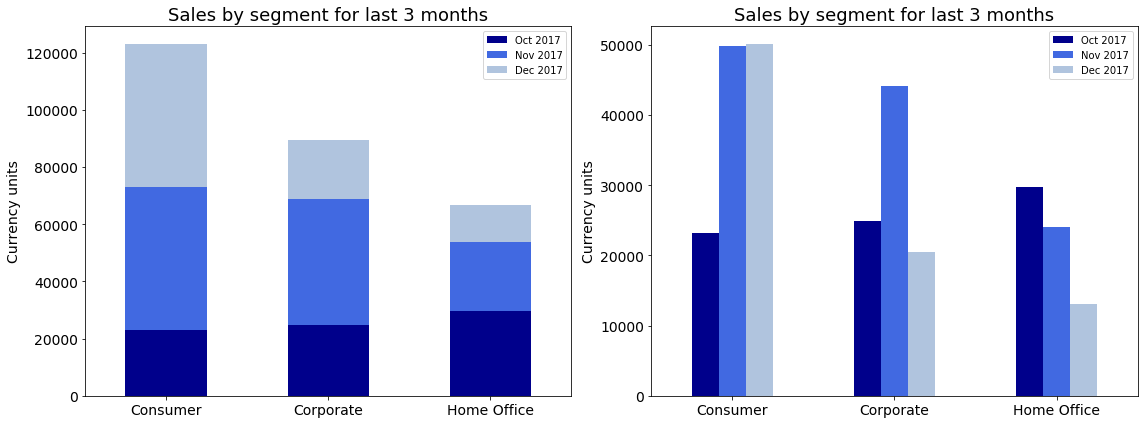

In [30]:
#segments sorted
cursor.execute('SELECT segment, SUM(amount) amount \
               FROM orders, line_items, customers \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id AND orders.id = order_id \
               GROUP BY segment ORDER BY SUM(amount) DESC')

seg_sorted = pd.DataFrame(cursor.fetchall(), columns=['segment', '']).set_index('segment')
seg_sorted = seg_sorted.rename_axis(index={'segment': ''})

#segments by sales last 3 months
cursor.execute('SELECT extract(month from order_date) as month, segment, SUM(amount) amount \
               FROM orders, line_items, customers \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id AND orders.id = order_id \
               GROUP BY month, segment ORDER BY month ASC')

df_3_seg = pd.DataFrame(cursor.fetchall(), columns=['month', 'segment', '']).set_index(['month', 'segment']).iloc[:,0]
df_3_seg = df_3_seg.rename_axis(index={'month': '', 'segment': ''})

segs_3 = [df_3_seg[m] for m in range(10, 13)]
segs_3_stack = pd.concat(segs_3, axis=1, sort=False)
segs_3_stack.columns = months_list
segs_3_stack = segs_3_stack.reindex(index = seg_sorted.index)

#plot
fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

ax = axes[0]
segs_3_stack.plot(ax=ax, kind='bar', fontsize=14, rot=0, stacked=True, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by segment for last 3 months', fontsize=18)

ax = axes[1]
segs_3_stack.plot(ax=ax, kind='bar', fontsize=14, rot=0, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by segment for last 3 months', fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: seems that the rise of sales in Nov 2017 is provided in the **Corporate** segment and with lesser amount by other 2 cumulatively.

Let's see closer at categories and sub_categories for each segment.

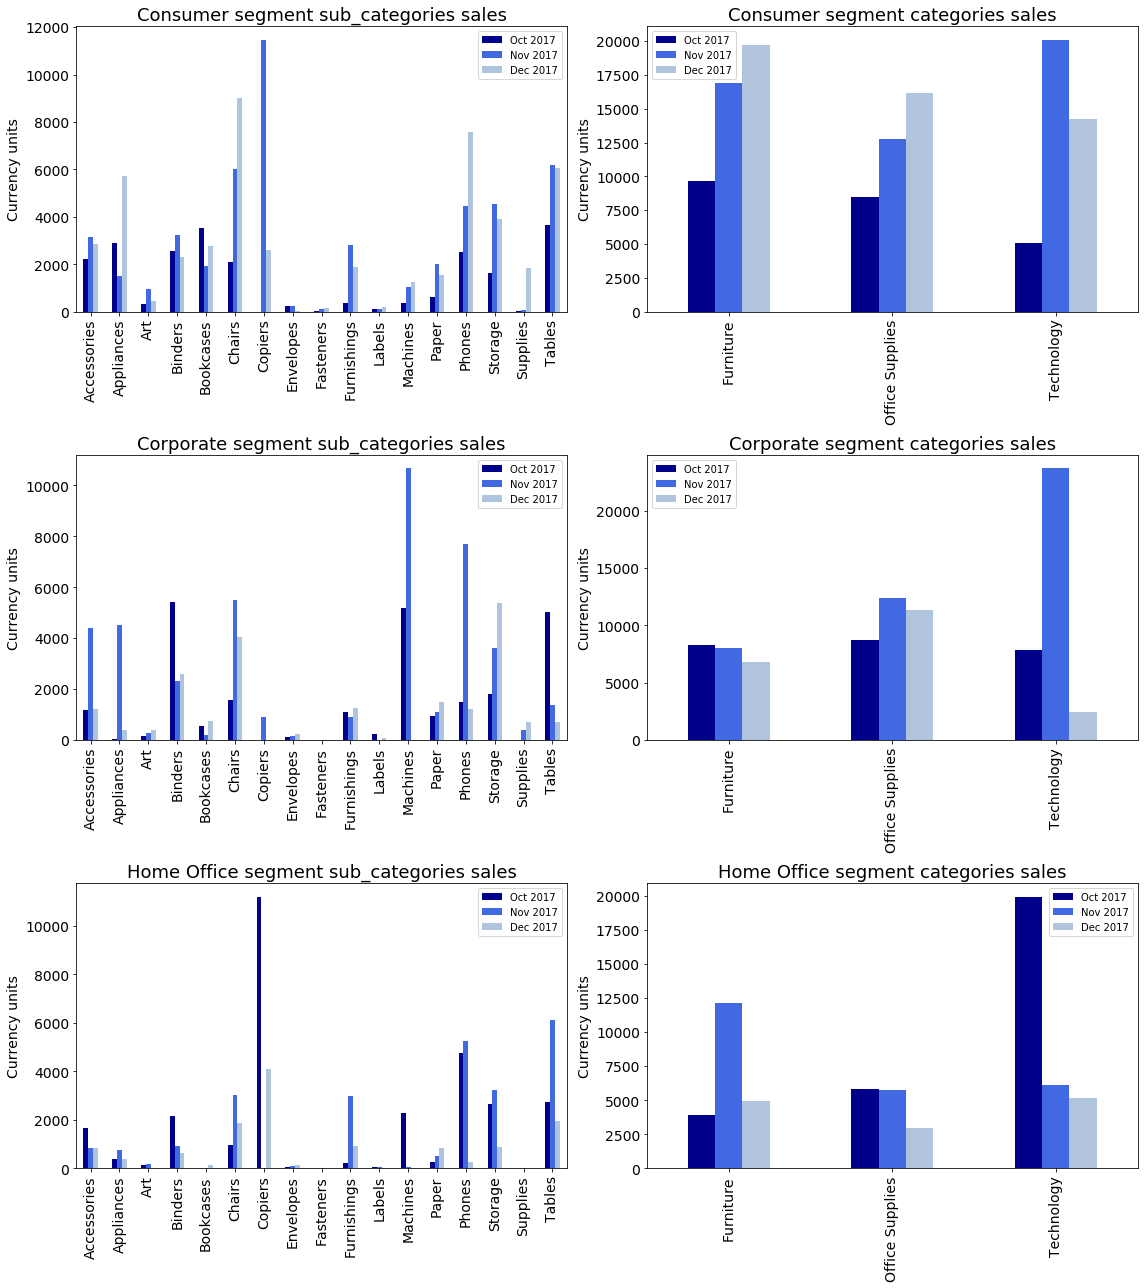

In [31]:
#sub_category by segment
cursor.execute('SELECT segment, extract(month from order_date) as month, sub_category, SUM(amount) amount \
               FROM orders, line_items, customers, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id AND orders.id = order_id AND products.id = product_id \
               GROUP BY segment, month, sub_category ORDER BY segment, month, sub_category ASC')

df_seg_subcat = pd.DataFrame(cursor.fetchall(), columns=['segment', 'month', 'sub_category', '']).set_index(['segment', 'month', 'sub_category']).iloc[:,0]
df_seg_subcat = df_seg_subcat.rename_axis(index={'month': '', 'sub_category': ''})

seg_subcats = []

for seg in seg_sorted.index:
    
    df_new = df_seg_subcat[seg]
    seg_subcat = [df_new[m] for m in range(10, 13)]
    seg_subcat_stack = pd.concat(seg_subcat, axis=1, sort=False)
    seg_subcat_stack.columns = months_list
    
    seg_subcats.append(seg_subcat_stack)

#category by segment
cursor.execute('SELECT segment, extract(month from order_date) as month, category, SUM(amount) amount \
               FROM orders, line_items, customers, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id AND orders.id = order_id AND products.id = product_id \
               GROUP BY segment, month, category ORDER BY segment, month, category ASC')

df_seg_cat = pd.DataFrame(cursor.fetchall(), columns=['segment', 'month', 'category', '']).set_index(['segment', 'month', 'category']).iloc[:,0]
df_seg_cat = df_seg_cat.rename_axis(index={'month': '', 'category': ''})

seg_cats = []

for seg in seg_sorted.index:
    
    df_new = df_seg_cat[seg]
    seg_cat = [df_new[m] for m in range(10, 13)]
    seg_cat_stack = pd.concat(seg_cat, axis=1, sort=False)
    seg_cat_stack.columns = months_list
    
    seg_cats.append(seg_cat_stack)
    
#plot
fig, axes = plt.subplots(figsize=(16,18), nrows=3, ncols=2)

for (i, seg) in enumerate(seg_sorted.index):
    
    ax = axes[i,0]
    seg_subcats[i].sort_index().plot(ax=ax, kind='bar', fontsize=14, color=colors)
    ax.set_ylabel('Currency units', fontsize=14)
    ax.set_title('{} segment sub_categories sales'.format(seg), fontsize=18)
    
    ax = axes[i,1]
    seg_cats[i].plot(ax=ax, kind='bar', fontsize=14, color=colors)
    ax.set_ylabel('Currency units', fontsize=14)
    ax.set_title('{} segment categories sales'.format(seg), fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: the rise of the Nov sales in Corporate segment is provided by **Machines** and **Phones**, which are groups from **Technology** category, which is coherent with conclusions from the previous charts.

Lastly, I'd like to see whether threr are factors from geographical point of view, especially by state.

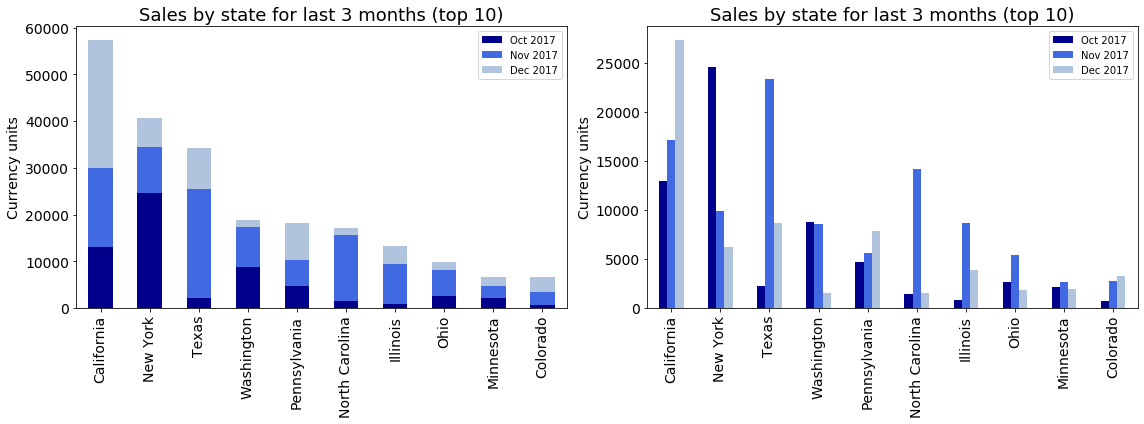

In [32]:
n = 10

#sorted states
cursor.execute('SELECT state, SUM(sales) sales \
               FROM orders, customers \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id \
               GROUP BY state ORDER BY SUM(sales) DESC')

states_sorted = pd.DataFrame(cursor.fetchall(), columns=['state', '']).set_index('state')
states_sorted = states_sorted.rename_axis(index={'state': ''})

#states by sales last 3 months
cursor.execute('SELECT extract(month from order_date) as month, state, SUM(sales) sales \
               FROM orders, customers \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id \
               GROUP BY month, state ORDER BY month ASC')

df_3_stat = pd.DataFrame(cursor.fetchall(), columns=['month', 'state', '']).set_index(['month', 'state']).iloc[:,0]
df_3_stat = df_3_stat.rename_axis(index={'month': '', 'state': ''})

states_3 = [df_3_stat[m] for m in range(10, 13)]
states_3_stack = pd.concat(states_3, axis=1, sort=False)
states_3_stack.columns = months_list
states_3_stack = states_3_stack.reindex(index = states_sorted.index)

#plot
fig, axes = plt.subplots(figsize=(16,6), nrows=1, ncols=2)

ax = axes[0]
states_3_stack[:n].plot(ax=ax, kind='bar', fontsize=14, stacked=True, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by state for last 3 months (top {})'.format(n), fontsize=18)

ax = axes[1]
states_3_stack[:n].plot(ax=ax, kind='bar', fontsize=14, color=colors)
ax.set_ylabel('Currency units', fontsize=14)
ax.set_title('Sales by state for last 3 months (top {})'.format(n), fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: the majority of sales, happening on Oct and Dec were provided by **California** and **New York** respectively. The sales on Nov were given to the great extent by **Texas** and **North Carolina**. **California** also has a great share, but it's comparatively outshadowed by Dec, so I will not consider it further. Since we focus on November, let's look closer at **Texas** and **North Carolina**.

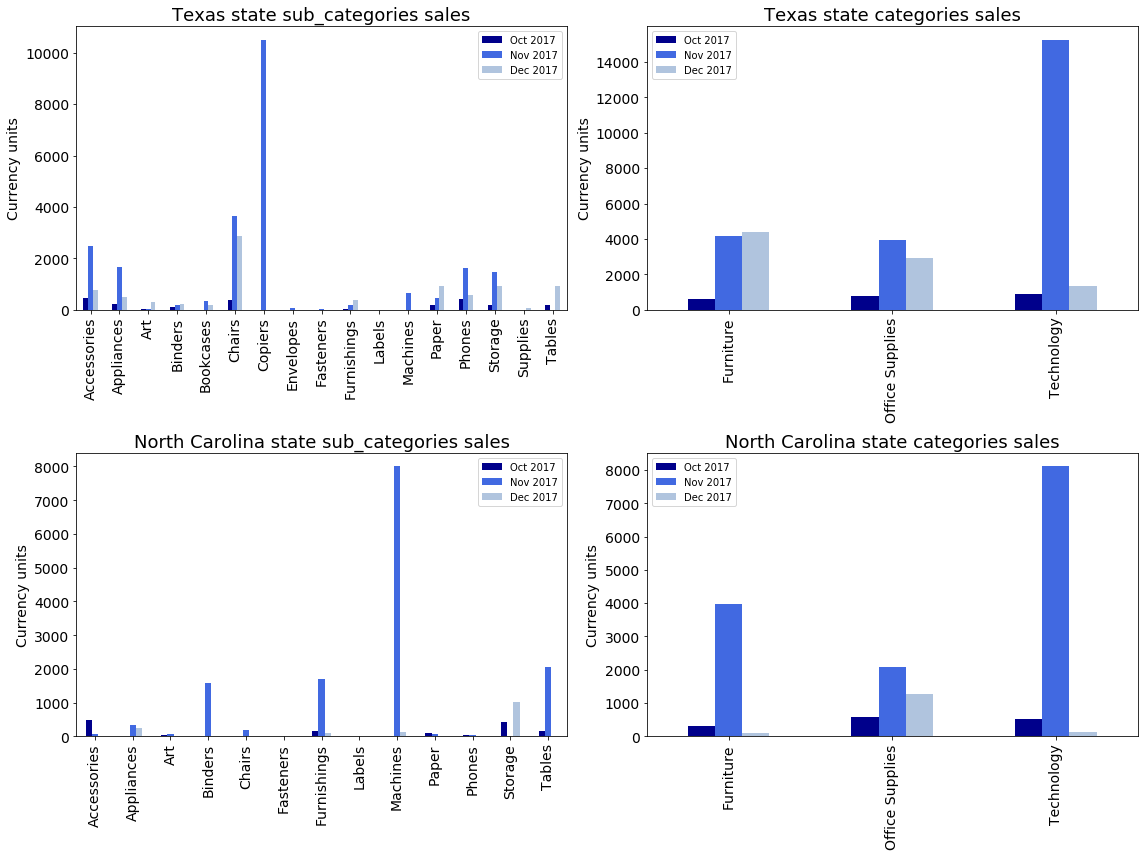

In [33]:
#sub_category by state
cursor.execute('SELECT state, extract(month from order_date) as month, sub_category, SUM(amount) amount \
               FROM orders, line_items, customers, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id AND orders.id = order_id AND products.id = product_id \
               GROUP BY state, month, sub_category ORDER BY sub_category ASC')

df_stat_subcat = pd.DataFrame(cursor.fetchall(), columns=['state', 'month', 'sub_category', '']).set_index(['state', 'month', 'sub_category']).iloc[:,0]
df_stat_subcat = df_stat_subcat.rename_axis(index={'month': '', 'sub_category': ''})

stat_subcats = []

for stat in ['Texas', 'North Carolina']:
    
    df_new = df_stat_subcat[stat]
    stat_subcat = [df_new[m] for m in range(10, 13)]
    stat_subcat_stack = pd.concat(stat_subcat, axis=1, sort=False)
    stat_subcat_stack.columns = months_list
    
    stat_subcats.append(stat_subcat_stack)

#category by state
cursor.execute('SELECT state, extract(month from order_date) as month, category, SUM(amount) amount \
               FROM orders, line_items, customers, products \
               WHERE extract(year from order_date) = 2017 AND extract(month from order_date) >= 10 AND \
               customers.id = customer_id AND orders.id = order_id AND products.id = product_id \
               GROUP BY state, month, category ORDER BY category ASC')

df_stat_cat = pd.DataFrame(cursor.fetchall(), columns=['state', 'month', 'category', '']).set_index(['state', 'month', 'category']).iloc[:,0]
df_stat_cat = df_stat_cat.rename_axis(index={'month': '', 'category': ''})

stat_cats = []

for stat in ['Texas', 'North Carolina']:
    
    df_new = df_stat_cat[stat]
    stat_cat = [df_new[m] for m in range(10, 13)]
    stat_cat_stack = pd.concat(stat_cat, axis=1, sort=False)
    stat_cat_stack.columns = months_list
    
    stat_cats.append(stat_cat_stack)
    
#plot
fig, axes = plt.subplots(figsize=(16,12), nrows=2, ncols=2)

for (i, stat) in enumerate(['Texas', 'North Carolina']):
    
    ax = axes[i,0]
    stat_subcats[i].sort_index().plot(ax=ax, kind='bar', fontsize=14, color=colors)
    ax.set_ylabel('Currency units', fontsize=14)
    ax.set_title('{} state sub_categories sales'.format(stat), fontsize=18)
    
    ax = axes[i,1]
    stat_cats[i].plot(ax=ax, kind='bar', fontsize=14, color=colors)
    ax.set_ylabel('Currency units', fontsize=14)
    ax.set_title('{} state categories sales'.format(stat), fontsize=18)

fig.tight_layout()
plt.show()

**Inference**: both states have an enormous share of sales on Nov 2017 exactly in **Technology** category, whose major role in Nov rise was discussed in previous charts. Texas's sub_category is concentrated in **Copiers**, while North Carolina's in **Machines**. Based on the chart **Consumer segment categories sale**, **Copiers** are sold within the group of **Consumers**, which is actually not our target group of **Corporate** segment. And then Carolina's **Machines** are in **Corporate** segment (based on the neighbouring chart).

In [34]:
cursor.close()
conn.close()